# Background

Whenever we use an LLM we would like to get the highest response quality but are often restricted to a limited cost budget. Closed models, such as GPT-4, are known to be the highest quality models, but they can get very expensive especially when running them on a very number of queries. On the other hand, OSS models can be much cheaper, but their responses may not be of the same quality, especially for complex or domain-specific queries.

The goal of this tutorial is to show you how you can train a "smart router", i.e. a model that can dynamically decide, based on the query text, whether to call a closed model or an OSS model. Here's a schematic view of a smart router:
![Smart Router](assets/router_schema.png)

The goal is to learn a smart router such that, given a set of queries, we can get responses with the highest overall quality while minimizing the total cost.

# Approach

We are going to train a classifier to decide, based only on the query text, whether to route the query to an OSS model vs. a closed one. In this tutorial, we will make the following design choices: 
1. We will quantify a response quality on a scale of `[1, 5]` (5-star).
2. For simplicity, we will assume that the closed always achieves 5-start quality. 
3. We will use GPT-4 as a representative of closed models and Mixtral 8x7B for OSS models.

More concurrently, let us assume that closed models have perfect a quality (5/5 score). our goal is to reduce cost significantly (say by 50%) while maintaining a high overal quality (4.8/5 score).


# Implementation overview

## 1) Generate labeled data

## 2) Finetune a classifier on labeled data
A smart router is a binary classifier that predicts `p(y=1|query)` -- the probability that an OSS model will produce a high quality response for the given query. 

## 3) Evaluate router model offline

## 4) Serve the router model


## Step 1: Generate labaled data

1. Given a set of queries, generate Mixtral model responses
2. Given a dataset `{(prompt,  Mixtral-response)}`, use llm-as-a-judge method to score responses in `[1, 5]`

For the purpose of this tutorial, we will use a the [Nectar dataset](https://huggingface.co/datasets/berkeley-nest/Nectar) which aggregates queries from multiple public datasets along with model generations of many LLMs.

In [1]:
import ray
import numpy as np
import pandas as pd

In [2]:
from datasets import load_dataset


# Load the full huggingface dataset
# TODO: double check if you need a token to access this dataset
nectar_data = load_dataset("berkeley-nest/Nectar")
nectar_df = nectar_data["train"].to_pandas()
nectar_df.head()

,prompt,answers,turns,num_responses,source,good_natured
0,\n\nHuman: 0.002 = 1000 \n1 = x?\n\nAssistant:,"[{'answer': 'To find the value of x, we can se...",1,7,[sharegpt],True
1,\n\nHuman: 0:00\nwhat's going on guys it's NAM...,[{'answer': 'Hello! It seems like you're shari...,1,7,[lmsys-chat-1m],True
2,\n\nHuman: 01011001 01001111 01010101 00100000...,[{'answer': 'The binary code you provided tran...,1,7,[anthropic-hh],True
3,"\n\nHuman: ""012345"", ""001122"", ""ee44aa"", ""abcd...","[{'answer': 'Sure, I can help you write a func...",1,7,[lmsys-chat-1m],True
4,\n\nHuman: #01 You are an assistant that helps...,"[{'answer': '{ ""thoughts"": ""Based on the c...",1,7,[lmsys-chat-1m],True


### describe the dataset
### explain that it contains responses by many models

In [3]:
# count the number of responses for each model
nectar_df_expanded = nectar_df.explode("answers")
nectar_df_expanded["model"] = nectar_df_expanded["answers"].apply(lambda x: x["model"])

display(nectar_df_expanded["model"].value_counts())

model
gpt-3.5-turbo               191770
gpt-4                       191487
gpt-4-0613                  182954
gpt-3.5-turbo-instruct      182900
mistral-7b-instruct-v0.1    182601
anthropic                   148844
llama-2-7b-chat              49926
vicuna-13b                   20962
llama-2-70b-chat             11802
vicuna-33b                    8160
llama-2-13b-chat              7680
wizardlm-13b                  7530
alpaca-13b                    6692
mpt-30b-chat                  6686
koala-13b                     6457
falcon-40b-instruct           5717
alpaca-7b                     5675
wizardlm-70b                  5625
wizardlm-7b                   5615
ultralm-13b                   5577
ultralm-65b                   5561
starchat                      5303
chatglm-6b                    3860
llama-13b                     3824
oasst-pythia-12b              3646
bard                          3159
fastchat-t5-3b                3155
dolly-v2-12b                  2817
claude-1      

### Explain that we will use a subset of the data with gpt-4 responses
### Also explain that we will filter the data to contain single turn, good natured and preprocess prompts and responses

In [4]:
from data_utils import preprocess_nectar

CLOSED_LLM = "gpt-4"
CLOSED_NAME = "gpt4"
nectar_gpt4_df = preprocess_nectar(nectar_df, CLOSED_LLM, CLOSED_NAME)

/home/ray/default/templates/templates/llm-router/data_processing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[model_name] = filtered_df['answers'].apply(lambda row: next((item['answer'] for item in row if item['model'] == model), None))


/home/ray/default/templates/templates/llm-router/data_processing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['prompt'] = filtered_df['prompt'].apply(lambda prompt: pattern_end.sub("", pattern_start.sub("", prompt)).strip())
/home/ray/default/templates/templates/llm-router/data_processing.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=['answers', 'num_responses', 'turns', 'good_natured'], inplace=True)


In [5]:
N_SUBSET = 10

# Sample a small subset from the dataset for the purpose of this tutorial
dataset_df = nectar_gpt4_df.sample(N_SUBSET, random_state=42)

### Generate Mixtral responses for prompt

In [4]:
from dotenv import load_dotenv
import os
from online_inference import generate_batch_responses
from data_utils import prepare_llm_queries

# store your API key in a .env file in the home directory
load_dotenv("/home/ray/.env")
API_BASE = os.getenv("ANYSCALE_API_BASE")
API_KEY = os.getenv("ANYSCALE_API_KEY")

# generate Mixtral responses with Anyscale's endpoint
OSS_LLM = "mistralai/Mixtral-8x7B-Instruct-v0.1"
OSS_NAME = "mixtral"
max_concurrent_queries = 25
temperature = 0.7
max_tokens = 512

llm_queries = prepare_llm_queries(dataset_df)

In [10]:
llm_responses = generate_batch_responses(
    API_BASE, API_KEY, OSS_LLM, llm_queries, max_concurrent_queries, temperature, max_tokens, verbose=True
)

Starting batch inference on 10 queries...


2024-05-03 18:28:42,278	INFO worker.py:1540 -- Connecting to existing Ray cluster at address: 10.0.49.108:6379...
2024-05-03 18:28:42,286	INFO worker.py:1715 -- Connected to Ray cluster. View the dashboard at https://session-flgz3w75nljuirfmesktfhtdhx.i.anyscaleuserdata.com 
2024-05-03 18:28:42,292	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_0a357ac8c78524cad566ac791b574556.zip' (0.08MiB) to Ray cluster...
2024-05-03 18:28:42,293	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_0a357ac8c78524cad566ac791b574556.zip'.


# queries un-processed: 9, in-progress: 1, ready: 0
# queries un-processed: 8, in-progress: 2, ready: 0
# queries un-processed: 7, in-progress: 3, ready: 0
# queries un-processed: 6, in-progress: 4, ready: 0
# queries un-processed: 5, in-progress: 5, ready: 0
# queries un-processed: 4, in-progress: 6, ready: 0
# queries un-processed: 3, in-progress: 7, ready: 0
# queries un-processed: 2, in-progress: 8, ready: 0
# queries un-processed: 1, in-progress: 9, ready: 0
# queries un-processed: 0, in-progress: 10, ready: 0
# queries un-processed: 0, in-progress: 9, ready: 1
# queries un-processed: 0, in-progress: 9, ready: 0
# queries un-processed: 0, in-progress: 9, ready: 0
# queries un-processed: 0, in-progress: 9, ready: 0
# queries un-processed: 0, in-progress: 9, ready: 0
# queries un-processed: 0, in-progress: 9, ready: 0
# queries un-processed: 0, in-progress: 9, ready: 0
# queries un-processed: 0, in-progress: 8, ready: 1
# queries un-processed: 0, in-progress: 7, ready: 1
# queries u

In [12]:
# merge responses with the dataset
dataset_df[OSS_NAME] = dataset_df.index.map(llm_responses)
dataset_df.head()
dataset_df.to_json("assets/test_dataset.json")

## Generate LLM-as-a-judge labels
1. explain judge template
2. explain how we will format and call API

In [2]:
import json
from data_utils import format_judge_prompt

dataset_df = pd.read_json("assets/test_dataset.json")

with open("assets/judge_template.json") as f:
    judge_template = json.load(f)

example = dataset_df.iloc[0]
print(
    format_judge_prompt(
        judge_template,
        question=example["prompt"],
        answer=example["mixtral"],
        reference_answer=example["gpt4"],
    )
)

[Instruction]
Evaluate the AI assistant's proficiency in answering the user question displayed below. Your evaluation should consider factors such as the helpfulness, relevance, adherence to real-world facts, depth, creativity, and level of detail of the response. You will be given a reference answer which is considered of high quality. Your assessment will have two lines: First line has a rating on a scale of 1 to 5 with a higher rating representing higher response quality. Follow strictly this format: "[[rating]]", for example: "[[3]]". Second line contains a short explanation of your rating.

[Question]
Based on the features mentioned, which hotel do you think is more preferable among the following hotels?
Hotel A: 
- Spa: Yes
- Swimming Pool: Yes
- Bar: Yes
- Restaurant: Yes
Hotel B: 
- Spa: No
- Swimming Pool: Yes
- Bar: Yes
- Restaurant: Yes
Hotel C: 
- Spa: Yes
- Swimming Pool: No
- Bar: No
- Restaurant: Yes
Here is the SQL database code to retrieve the data:
SELECT * FROM hotel

In [5]:
from dotenv import load_dotenv
import os
from online_inference import generate_batch_responses
from data_utils import prepare_llm_judge_queries

# store your API key in a .env file in the home directory
load_dotenv("/home/ray/.env")
API_BASE = os.getenv("OPENAI_API_BASE")
API_KEY = os.getenv("OPENAI_API_KEY")

# generate gpt4 as a judge labels with openai api
JUDGE_LLM = "gpt-4"
max_concurrent_queries = 10
temperature = 0
max_tokens = 256

judge_queries = prepare_llm_judge_queries(dataset_df, judge_template)

In [6]:
judge_responses = generate_batch_responses(
    API_BASE, API_KEY, JUDGE_LLM, judge_queries, max_concurrent_queries, temperature, max_tokens, verbose=True
)

Starting batch inference on 10 queries...


2024-05-03 19:01:14,386	INFO worker.py:1540 -- Connecting to existing Ray cluster at address: 10.0.49.108:6379...
2024-05-03 19:01:14,394	INFO worker.py:1715 -- Connected to Ray cluster. View the dashboard at https://session-flgz3w75nljuirfmesktfhtdhx.i.anyscaleuserdata.com 
2024-05-03 19:01:14,400	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_723e3ed169539c39dc905d07aa319dbb.zip' (0.09MiB) to Ray cluster...
2024-05-03 19:01:14,401	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_723e3ed169539c39dc905d07aa319dbb.zip'.


# queries un-processed: 9, in-progress: 1, ready: 0
# queries un-processed: 8, in-progress: 2, ready: 0
# queries un-processed: 7, in-progress: 3, ready: 0
# queries un-processed: 6, in-progress: 4, ready: 0
# queries un-processed: 5, in-progress: 5, ready: 0
# queries un-processed: 4, in-progress: 6, ready: 0
# queries un-processed: 3, in-progress: 7, ready: 0
# queries un-processed: 2, in-progress: 8, ready: 0
# queries un-processed: 1, in-progress: 8, ready: 1
# queries un-processed: 0, in-progress: 9, ready: 0
# queries un-processed: 0, in-progress: 8, ready: 1
# queries un-processed: 0, in-progress: 7, ready: 1
# queries un-processed: 0, in-progress: 7, ready: 0
# queries un-processed: 0, in-progress: 6, ready: 1
# queries un-processed: 0, in-progress: 5, ready: 1
# queries un-processed: 0, in-progress: 4, ready: 1
# queries un-processed: 0, in-progress: 4, ready: 0
# queries un-processed: 0, in-progress: 3, ready: 1
# queries un-processed: 0, in-progress: 3, ready: 0
# queries un

In [7]:
judge_responses

{134702: "[[5]]\nThe assistant's response is highly detailed, relevant, and accurate. It covers all the key points mentioned in the reference answer and adds an additional point about pay transparency. The assistant also provides a useful reminder that trends can vary based on specific contexts, which adds depth to the response.",
 27244: "[[5]]\nThe assistant's response is highly detailed, accurate, and helpful. It provides a Python-based solution to the problem, explaining each step of the algorithm in a clear and understandable manner. The assistant also mentions potential limitations and suggests possible improvements, which aligns with the reference answer. The assistant's response is on par with the reference answer in terms of quality and depth.",
 131095: "[[5]]\nThe assistant's response is highly detailed, accurate, and provides a comprehensive explanation of the JavaScript code snippet. It goes above and beyond the reference answer in terms of depth, creativity, and level of 

In [9]:
from online_inference import parse_judge_responses
labels, explanations = parse_judge_responses(judge_responses)

In [11]:
dataset_df['label'] = dataset_df.index.map(labels)
dataset_df.to_json("assets/labeled_test_dataset.json")
dataset_df.head()


,prompt,source,gpt4,mixtral,label
6062,"Based on the features mentioned, which hotel d...",[evol_instruct],"Based on the features mentioned, Hotel A seems...","Based on the information provided, I would sa...",5
113830,Provide step-by-step instructions on how to cr...,[ultrachat],"Sure, here's a simple step-by-step guide on ho...","Sure, I'd be happy to help you make a homemad...",4
138869,What are the 10 largest cities in the US by po...,[lmsys-chat-1m],"As of the most recent data available, the 10 l...","Sure, I'd be happy to help with that! As of t...",5
169249,Write a comparison essay of at least 500 words...,[ultrachat],Title: A Comparative Analysis of Driving a Car...,Title: The Great Debate: Driving a Car vs. Ri...,3
116934,"Q: You are provided with an ""Event"", ""Intent"" ...",[flan_v2_niv2],PersonX might feel satisfied or content using ...,Person X probably feels comfortable and satis...,5


## Assume we labeled the full dataset (~120K samples)

1. will load the dataset and explore label stats
2. split it to train and validation sets
3. Prepare data for the finetuning: balance labels, and ft format

In [3]:
import pandas as pd
dataset_df = pd.read_json("/mnt/user_storage/templates_data/labeled_full_dataset.jsonl", lines=True, orient="records")

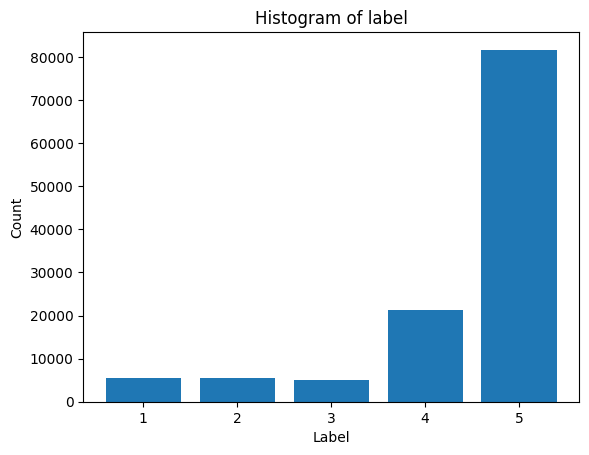

In [4]:
from data_utils import visualize_label_distribution

# visualize the label distribution
visualize_label_distribution(dataset_df, key='label')


Explain why we higher % for 4-5 scores (Mixtral is competitive with GPT-4 06-2023 version)

Let us assume that if the score >= 4 then we will route to the OSS model (the response quality is good enough), otherwise, we will route the closed model. Under this assumption, the data distribution looks like:

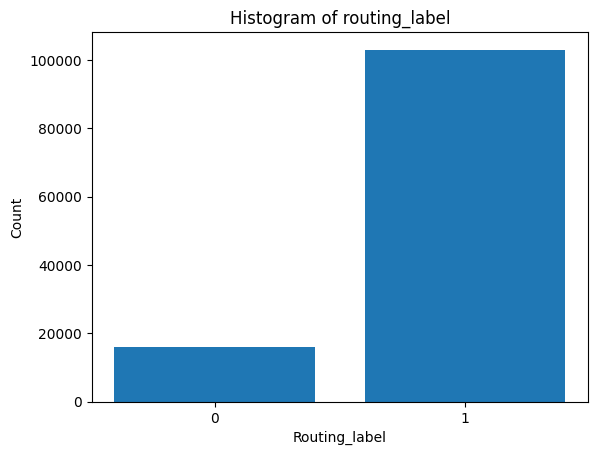

In [5]:
dataset_df['routing_label'] = dataset_df['label'].apply(lambda x: 1 if x >= 4 else 0)
visualize_label_distribution(dataset_df, key='routing_label')

In [6]:
from data_utils import split_dataset, balance_dataset

# split data to train/validation sets
train_df, validation_df = split_dataset(dataset_df, validation_size=5000)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(validation_df)}")

Train size: 114101
Validation size: 5000


It's recommended to train and validate classification tasks on balanced datasests, so that the model and metrics are unbiased to one label. Let's create a balanced train and validation sets.

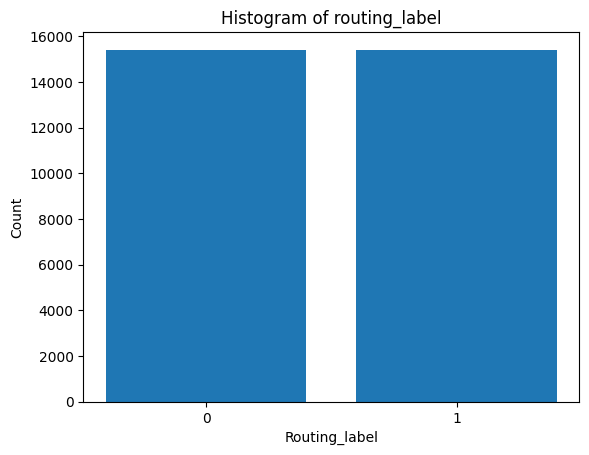

Train size: 30832
Validation size: 1378


In [7]:
balanced_train_df = balance_dataset(train_df, key='routing_label')
balanced_validation_df = balance_dataset(validation_df, key='routing_label')

visualize_label_distribution(balanced_train_df, key='routing_label')

print(f"Train size: {len(balanced_train_df)}")
print(f"Validation size: {len(balanced_validation_df)}")

Format data in Anyscale finetuning format

In [8]:
from data_utils import prepare_ft_messages

balanced_train_df['messages'] = prepare_ft_messages(balanced_train_df)
balanced_validation_df['messages'] = prepare_ft_messages(balanced_validation_df)

# for debugging, here's what the messages look like:
display(balanced_train_df['messages'].iloc[0])

[{'role': 'system',
  'content': '[Instruction]\nBased on the question provided below, predict the score an expert evaluator would give to an AI assistant\'s response, considering the expected helpfulness, relevance, adherence to real-world facts, depth, creativity, and level of detail necessary for a high-quality answer. Your prediction should not be based on an actual answer but should infer the level of proficiency required to address the question effectively. Score predictions should be on a scale from 1 to 5, where a higher score represents a higher anticipated quality of response. Provide your prediction in the following format: "[[predicted rating]]".\n'},
 {'role': 'user',
  'content': 'Remember, a high score (4-5) suggests that the question demands a response of very high quality, showing deep understanding, creativity, and detailed insight. A medium score (3) indicates that the question can be adequately addressed with a moderate level of detail and relevance. A low score (1-

[{'role': 'system',
  'content': '[Instruction]\nBased on the question provided below, predict the score an expert evaluator would give to an AI assistant\'s response, considering the expected helpfulness, relevance, adherence to real-world facts, depth, creativity, and level of detail necessary for a high-quality answer. Your prediction should not be based on an actual answer but should infer the level of proficiency required to address the question effectively. Score predictions should be on a scale from 1 to 5, where a higher score represents a higher anticipated quality of response. Provide your prediction in the following format: "[[predicted rating]]".\n'},
 {'role': 'user',
  'content': 'Remember, a high score (4-5) suggests that the question demands a response of very high quality, showing deep understanding, creativity, and detailed insight. A medium score (3) indicates that the question can be adequately addressed with a moderate level of detail and relevance. A low score (1-

{
  "role": "system",
  "content": "[Instruction]\nBased on the question provided below, predict the score an expert evaluator would give to an AI assistant's response, considering the expected helpfulness, relevance, adherence to real-world facts, depth, creativity, and level of detail necessary for a high-quality answer. Your prediction should not be based on an actual answer but should infer the level of proficiency required to address the question effectively. Score predictions should be on a scale from 1 to 5, where a higher score represents a higher anticipated quality of response. Provide your prediction in the following format: \"[[predicted rating]]\".\n"
}
